In [193]:
import os
import glob
import olefile
import zlib
import struct
import re
import ast
import pandas as pd

In [194]:
import os
import sys

import openai

import random
import pandas as pd
from tqdm import tqdm
import numpy as np

In [195]:
from langchain import PromptTemplate
from langchain.output_parsers import CommaSeparatedListOutputParser

from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain
from langchain.callbacks import get_openai_callback
import uuid

In [196]:
pd.set_option('mode.chained_assignment',  None)
from IPython.display import clear_output

### <span style="font-family: montserrat; font-weight: bold; font-size: 35px">Import data</Span>

In [197]:
raw_general = pd.read_excel("./data/2021 국정과제 일반국민 오픈 데이터_report3_20088461_2.xlsx", header=0)

In [198]:
opinion_df = raw_general[(raw_general['문5-2']==3) & (raw_general['과제num']<=100)].reset_index(drop=True)

In [199]:
opinion_df['문5-5'] = opinion_df['문5-5'].astype('int')
opinion_df = opinion_df.drop(['책형 타입', '문5-2', '문5-3', '문5-4'], axis=1)
opinion_df.columns = ['SAV_ID', '구분', 'policy', 'category', 'text']
opinion_df

,SAV_ID,구분,policy,category,text
0,3,일반국민,74,2,정부가 추진되는일이 잘 해결되길 바랍니다
1,6,일반국민,12,4,공공기관의 보여주기식 행정으로 시민의 적극적 의견이 반영되지 않는 것이 문제라고 생...
2,6,일반국민,60,4,탈원전에 따른 국민 혜택 및 불안요소에 대해 적극적으로 소통 및 의사반영이 부족하다.
3,7,일반국민,5,4,"길게 들고가야할 부분인것을 충분히 인지하나, 핵심포인트에대한 설명이 강조되지않음."
4,7,일반국민,21,1,"서민을 생각하고 서민을 위한 복지가 더욱 많아질수 있도록 노력하는 모습, 빈곤층 사..."
...,...,...,...,...,...
22719,10650,일반국민,98,5,"홍보및 내용설명이 부족, 잘알아듣지 못하겠다"
22720,10651,일반국민,41,8,청년층의 초기 사회 정착을 위한 비용이 예전보다 과다하게 소요되고 있어 정부의 적극...
22721,10651,일반국민,73,3,"보여주기식 item 선정 보다 , (한 지자체에서 성공하면 그대로 가져와서 적용하는..."
22722,10653,일반국민,4,7,"표현의 자유를 싫컷 누리는 언론들에 대해 악의적 오, 편집 보도에 대해서는 두번다시..."


In [200]:
folder_path = './data/국정과제'  
file_extension = '.hwp'  
file_list = glob.glob(os.path.join(folder_path, '*' + file_extension))
file_names = [os.path.basename(file) for file in file_list]

In [201]:
def get_hwp_text(filename):
    f = olefile.OleFileIO(filename)
    dirs = f.listdir()

    if ["FileHeader"] not in dirs or \
       ["\x05HwpSummaryInformation"] not in dirs:
        raise Exception("Not Valid HWP.")

    header = f.openstream("FileHeader")
    header_data = header.read()
    is_compressed = (header_data[36] & 1) == 1

    nums = []
    for d in dirs:
        if d[0] == "BodyText":
            nums.append(int(d[1][len("Section"):]))
    sections = ["BodyText/Section"+str(x) for x in sorted(nums)]

    text = ""
    for section in sections:
        bodytext = f.openstream(section)
        data = bodytext.read()
        if is_compressed:
            unpacked_data = zlib.decompress(data, -15)
        else:
            unpacked_data = data
    
        section_text = ""
        i = 0
        size = len(unpacked_data)
        while i < size:
            header = struct.unpack_from("<I", unpacked_data, i)[0]
            rec_type = header & 0x3ff
            rec_len = (header >> 20) & 0xfff

            if rec_type in [67]:
                rec_data = unpacked_data[i+4:i+4+rec_len]
                section_text += rec_data.decode('utf-16')
                section_text += "\n"

            i += 4 + rec_len

        text += section_text
        text += "\n"

    return text

In [202]:
def postprocessing(d):
    match = re.search(r'국정\r\n\d{3}\r\n', d)
    start_index = match.end()
    result = d[start_index:]
    result = re.sub('[^가-힣0-9a-zA-Z,.\(\)\'"· ]', ' ', result)    
    result = re.sub(' +', ' ', result)
    return result

In [203]:
policy_df = pd.DataFrame(columns=['policy', 'desc'])

for filename in file_names:
    p_idx = re.search(r'국정(\d{2,3})', filename).group(1)
    raw = get_hwp_text(f'data/국정과제/{filename}')
    result = postprocessing(raw)
    policy_df.loc[len(policy_df)] = [p_idx, result]    
    
policy_df['policy'] = policy_df['policy'].astype('int')

# <span style="font-family: montserrat; font-weight: bold; font-size: 35px">Topicmodeling</Span>

## <span style="font-family: montserrat; font-weight: bold; font-size: 25px">Tokenizing</Span>

In [815]:
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords
import re

In [816]:
kiwi = Kiwi(model_type='sbg')

In [817]:
with open(f'nnp_231002.txt', 'r') as f:
    custom_nnp = f.read().splitlines()

for word in custom_nnp:
    kiwi.add_user_word(word, 'NNP', 10)

In [818]:
stopwords = Stopwords()

In [821]:
with open(f'custom_stopwords_231002.txt', 'r') as f:
    custom_stopwords = f.read().splitlines()

for word in custom_stopwords:
    stopwords.add((word, 'NNP'))
    stopwords.add((word, 'NNG'))
    stopwords.add((word, 'SL'))

In [822]:
def kiwi_tokenizer(d):
    result = re.sub("[^가-힣A-Za-z ]", " ", d)
    result = result.lower()
    result = kiwi.tokenize(result,  stopwords=stopwords)
    result = [_.form for _ in result if _.tag=='NNP' or _.tag=='NNG' or _.tag=='SL']
    result = [word for word in result if len(word) > 1]
    return result

# <span style="font-family: montserrat; font-weight: bold; font-size: 35px">LDA(Tomoto)</Span>

In [837]:
from tqdm import tqdm
import tomotopy as tp
import matplotlib.pyplot as plt

In [824]:
tokenized_texts = opinion_df['text'].apply(kiwi_tokenizer)

In [830]:
model = tp.LDAModel(k=20, alpha=0.1, eta=0.01, min_cf=5, rm_top=0)
for i, keywords in enumerate(tokenized_texts):
    model.add_doc(keywords)
    if i % 1000 == 0: print('Document #{} has been loaded'.format(i))

Document #0 has been loaded
Document #1000 has been loaded
Document #2000 has been loaded
Document #3000 has been loaded
Document #4000 has been loaded
Document #5000 has been loaded
Document #6000 has been loaded
Document #7000 has been loaded
Document #8000 has been loaded
Document #9000 has been loaded
Document #10000 has been loaded
Document #11000 has been loaded
Document #12000 has been loaded
Document #13000 has been loaded
Document #14000 has been loaded
Document #15000 has been loaded
Document #16000 has been loaded
Document #17000 has been loaded
Document #18000 has been loaded
Document #19000 has been loaded
Document #20000 has been loaded
Document #21000 has been loaded
Document #22000 has been loaded


In [831]:
model.train(0) 
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)

Total docs: 21874
Total words: 99927
Vocab size: 2293


In [832]:
model.removed_top_words

[]

In [833]:
model.vocab_freq

array([2517, 2186, 1683, ...,    1,    1,    1], dtype=uint64)

In [834]:
for i in range(1000):
    if (i+1) % 1000 == 0:
        print(f'Iteration {i+1}\tLL per word: {model.ll_per_word:.4f}\t Perplexity: {model.perplexity:.4f}')
    model.train(1)
 
for i in range(model.k):
    res = model.get_topic_words(i, top_n=10)
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))

Iteration 1000	LL per word: -6.8996	 Perplexity: 991.9246
Topic #0	강화, 처벌, 보호, 범죄, 피해, 피해자, 사회, 강력, 인권, 아동
Topic #1	기업, 중소기업, 규제, 지원, 국가, 개선, 성장, 상생, 시장, 재벌
Topic #2	일자리, 창출, 청년, 임금, 노력, 정규직, 취업, 격차, 기업, 고용
Topic #3	개선, 소득, 유통, 안정, 농어업, 농촌, 농업, 동물, 소비자, 안전
Topic #4	지원, 혜택, 상공인, 실질, 세금, 확대, 코로나, 소득, 자영업자, 도움
Topic #5	산업, 미래, 지원, 환경, 투자, 발전, 개발, 기술, 육성, 과학
Topic #6	노력, 추진, 실질, 지속, 성과, 적극, 현실, 만족, 개선, 과제
Topic #7	지원, 코로나, 노력, 산업, 적극, 문화, 해외, 환경, 변화, 세계
Topic #8	사회, 공정, 투명, 노력, 평등, 개선, 차별, 노동, 공무원, 인사
Topic #9	홍보, 부족, 적극, 노력, 지원, 참여, 다양, 소통, 추진, 관심
Topic #10	지방, 발전, 도시, 수도, 균형, 자치, 재정, 분권, 집중, 주민
Topic #11	서민, 주택, 주거, 부동산, 대출, 청년, 금융, 환경, 신혼부부, 투기
Topic #12	교통, 이용, 서비스, 공공, 행정, 통신비, 절감, 시스템, 구축, 혜택
Topic #13	의견, 개혁, 비리, 청산, 기관, 정치, 수렴, 적폐, 권력, 검찰
Topic #14	관리, 강화, 안전, 대응, 중국, 감독, 불법, 재난, 해양, 사고
Topic #15	지원, 계층, 소외, 확대, 복지, 공공, 사회, 취약, 서비스, 의료
Topic #16	교육, 학교, 아이, 학생, 대학, 지원, 청소년, 환경, 강화, 직업
Topic #17	개선, 보장, 건강, 출산, 지원, 보험, 노인, 혜택, 확대, 장병
Topic #18	언론, 자유, 뉴스, 표현, 가짜, 보도, 백신, 독립, 요소, 사태


## <span style="font-family: montserrat; font-weight: bold; font-size: 35px">Optimal K search</Span>

In [835]:
perp_list = dict()
coh_list = dict()
topic_min = 5
topic_max = 50
rm_top = len(model.removed_top_words)

for topic_num in tqdm(range(topic_min, topic_max+1)):
    model = tp.LDAModel(k=topic_num, alpha=0.1, eta=0.01, min_cf=5, rm_top=rm_top)
    for i, keywords in enumerate(tokenized_texts):
        model.add_doc(keywords)
    model.train(1000)
    perp_list[topic_num] = model.perplexity
    coh_list[topic_num] = tp.coherence.Coherence(model).get_score()

100%|██████████| 46/46 [03:34<00:00,  4.66s/it]


In [836]:
top_k = 10
l_perp_topic = sorted(perp_list, key=lambda k: perp_list[k])[:top_k]
h_coh_topic = sorted(coh_list, key=lambda k: coh_list[k], reverse=True)[:top_k]
print(l_perp_topic)
print(h_coh_topic)
print(list(set(l_perp_topic) & set(h_coh_topic)))

[13, 10, 11, 17, 5, 9, 15, 16, 6, 8]
[6, 7, 5, 10, 14, 11, 8, 21, 13, 23]
[5, 6, 8, 10, 11, 13]


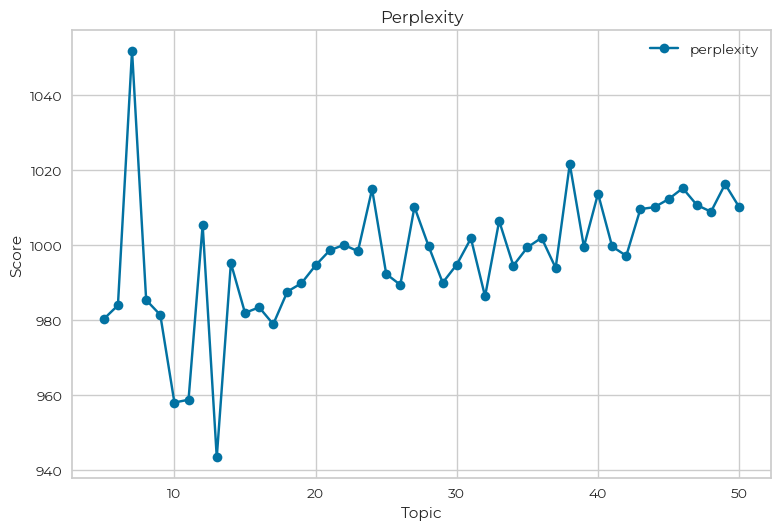

In [913]:
topics = list(perp_list.keys())
perp_values = [perp_list[topic] for topic in topics]

plt.plot(topics, perp_values, label='perplexity', marker='o')
plt.xlabel('Topic')
plt.ylabel('Score')
plt.title('Perplexity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('./plot/perplexity_231003.png', dpi = 600)

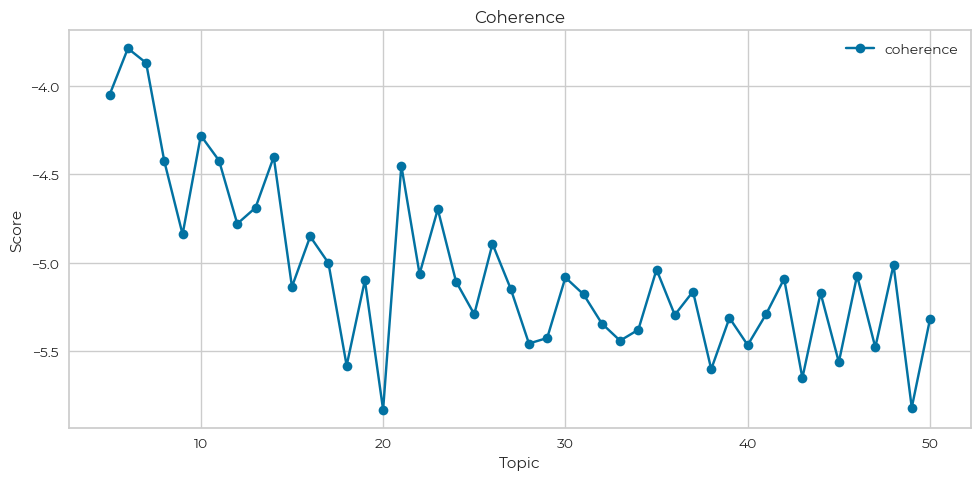

In [916]:
topics = list(coh_list.keys())
coh_values = [coh_list[topic] for topic in topics]

plt.figure(figsize=(10, 5))
plt.plot(topics, coh_values, label='coherence', marker='o')
plt.xlabel('Topic')
plt.ylabel('Score')
plt.title('Coherence')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('./plot/coherence_231003.png', dpi = 600)

## <span style="font-family: montserrat; font-weight: bold; font-size: 35px">Result</Span>

In [884]:
k = 48
model = tp.LDAModel(k=k, alpha=0.1, eta=0.01, min_cf=5, rm_top=rm_top)

for i, keywords in enumerate(tokenized_texts):
    model.add_doc(keywords)
    if i % 1000 == 0: print('Document #{} has been loaded'.format(i))

Document #0 has been loaded
Document #1000 has been loaded
Document #2000 has been loaded
Document #3000 has been loaded
Document #4000 has been loaded
Document #5000 has been loaded
Document #6000 has been loaded
Document #7000 has been loaded
Document #8000 has been loaded
Document #9000 has been loaded
Document #10000 has been loaded
Document #11000 has been loaded
Document #12000 has been loaded
Document #13000 has been loaded
Document #14000 has been loaded
Document #15000 has been loaded
Document #16000 has been loaded
Document #17000 has been loaded
Document #18000 has been loaded
Document #19000 has been loaded
Document #20000 has been loaded
Document #21000 has been loaded
Document #22000 has been loaded


In [885]:
model.train(0) 
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)

Total docs: 21874
Total words: 99927
Vocab size: 2293


In [886]:
model.removed_top_words

[]

In [887]:
model.vocab_freq

array([2517, 2186, 1683, ...,    1,    1,    1], dtype=uint64)

In [888]:
for i in range(1000):
    if (i+1) % 1000 == 0:
        print(f'Iteration {i+1}\tLL per word: {model.ll_per_word:.4f}\t Perplexity: {model.perplexity:.4f}')
    model.train(1)

for i in range(model.k):
    res = model.get_topic_words(i, top_n=10)
    print('Topic #{}'.format(i+1), end='\t')
    print(', '.join(w for w, p in res))

Iteration 1000	LL per word: -6.9141	 Perplexity: 1006.3763
Topic #1	지원, 문화, 예술인, 창작, 시설, 스포츠, 보장, 활동, 예술, 확대
Topic #2	만족, 노력, 전반, 개선, 해결, 방향, 시행, 진행, 결과, 긍정
Topic #3	개선, 장병, 복무, 군대, 기간, 국방, 군인, 인권, 처우, 급식
Topic #4	출산, 지원, 아이, 돌봄, 가정, 육아, 부모, 극복, 여성, 아동
Topic #5	계층, 소외, 지원, 사회, 취약, 복지, 혜택, 약자, 배려, 확대
Topic #6	문화, 한류, 확산, 확대, 부담, 혜택, 지원, 청년, 세계, 경감
Topic #7	보호, 해외, 지원, 체류, 강화, 동포, 재외, 적극, 신고, 국내
Topic #8	외교, 국가, 협력, 강화, 관계, 중국, 노력, 국익, 일본, 주변
Topic #9	서민, 대출, 지원, 규제, 코로나, 금융, 부채, 재산, 백신, 금리
Topic #10	언론, 자유, 뉴스, 표현, 가짜, 보도, 독립, 방송, 사실, 책임
Topic #11	관리, 안전, 강화, 감독, 사고, 재난, 철저, 체계, 예방, 지속
Topic #12	미디어, 사용, 활용, 홍보, 어르신, 건강, 처리, 영상, 금지, 발전
Topic #13	개혁, 청산, 적폐, 권력, 정치, 검찰, 기관, 언론, 참여, 부패
Topic #14	공무원, 업무, 기관, 경찰, 신청, 느낌, 전문, 자세, 역할, 의식
Topic #15	강화, 전환, 전작권, 동맹, 한미, 대응, 북한, 관계, 위협, 조기
Topic #16	지원, 상공인, 코로나, 혜택, 자영업자, 소득, 지원금, 실질, 기준, 세금
Topic #17	실질, 현실, 방안, 구체, 행정, 도움, 대책, 노력, 마련, 개선
Topic #18	산업, 관광, 개발, 구축, 활성, 시스템, 강국, 인프라, 해운, 도시
Topic #19	일자리, 창출, 청년, 확충, 양질, 취업, 노력, 안정, 공공, 고용
Topi

In [889]:
model.summary()

<Basic Info>
| LDAModel (current version: 0.12.4)
| 21874 docs, 99927 words
| Total Vocabs: 7396, Used Vocabs: 2293
| Entropy of words: 6.65185
| Entropy of term-weighted words: 6.65185
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 1000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -6.91613
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 5 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 48 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 3513576315 (random seed)
| trained in version 0.12.4
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.019499

In [890]:
topic_keywords_df = pd.DataFrame(columns=[f"Keyword_{i+1}" for i in range(10)])
topic_keywords_df['Topic'] = [f"Topic_{i+1}" for i in range(model.k)]
cols = list(topic_keywords_df.columns)
cols = [cols[-1]] + cols[:-1]
topic_keywords_df = topic_keywords_df[cols]

for topic_num in range(model.k):  
    topic_keywords = model.get_topic_words(topic_num, top_n=10)
    keywords_only = [keyword for keyword, _ in topic_keywords]
    topic_keywords_df.iloc[topic_num, 1:] = keywords_only

In [ ]:
topic_keywords_df['keywords'] = topic_keywords_df.iloc[:, 1:].T.apply(", ".join)

In [891]:
topic_keywords_df

,Topic,Keyword_1,Keyword_2,Keyword_3,Keyword_4,Keyword_5,Keyword_6,Keyword_7,Keyword_8,Keyword_9,Keyword_10
0,Topic_1,지원,문화,예술인,창작,시설,스포츠,보장,활동,예술,확대
1,Topic_2,만족,노력,전반,개선,해결,방향,시행,진행,결과,긍정
2,Topic_3,개선,장병,복무,군대,기간,국방,군인,인권,처우,급식
3,Topic_4,출산,지원,아이,돌봄,가정,육아,부모,극복,여성,아동
4,Topic_5,계층,소외,지원,사회,취약,복지,혜택,약자,배려,확대
5,Topic_6,문화,한류,확산,확대,부담,혜택,지원,청년,세계,경감
6,Topic_7,보호,해외,지원,체류,강화,동포,재외,적극,신고,국내
7,Topic_8,외교,국가,협력,강화,관계,중국,노력,국익,일본,주변
8,Topic_9,서민,대출,지원,규제,코로나,금융,부채,재산,백신,금리
9,Topic_10,언론,자유,뉴스,표현,가짜,보도,독립,방송,사실,책임


In [892]:
doc_topic_dists = np.stack([model.docs[i].get_topic_dist() for i in range(len(model.docs))])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
column_names = ["topic_" + str(i+1) for i in range(model.k)]
doc_topic_dists_df = pd.DataFrame(doc_topic_dists, columns=column_names)

In [911]:
topic_keywords_df.to_excel(f"./data/lda_{model.k}_keywords_231002.xlsx")
topic_dists_df.to_excel(f"./data/lda_{model.k}_topic_dist_231002.xlsx")

### <span style="font-family: montserrat; font-weight: bold; font-size: 35px">Prompt setting</Span>

In [ ]:
output_parser = CommaSeparatedListOutputParser()
format_instructions = output_parser.get_format_instructions()

prompt = PromptTemplate(
    template="""
    You have been given information about a government policy in South Korea and a list of people's suggestions for improvements to that policy, and your task is to categorize each suggestion.
    Choose which category each suggestion is most relevant to. 
    Categorize comments that do not fit into categories 1 through 11 as category 12.

    1. 정부정책이 공정한 기준에 따라 적용되고 있다는 신뢰를 줘야 함
    2. 다양한 이해관계자들의 의견이 반영 및 수렴되어야 함(정부정책에 의해 갈등이 발생하지 않아야 함)
    3. 현장 전문가와 실무자의 관점이 정책에 반영되어야 함(탁상공론이 되지 않도록 전문성을 높여야 함)
    4. 정부정책을 더 많은 국민들이 쉽게 알 수 있도록 더 많이 홍보해야 함
    5. 정부정책이 더 투명하게 집행되어야 함(정책에 대한 모니터링 등)
    6. 정부정책의 효과가 더 잘 체감될 수 있도록 해야 함
    7. 정부가 더 적극적으로 개입해야 함
    8. 정부정책이 일회성으로 종료되면 안 되고 지속성 있게 추진되어야 함
    9. 정부정책에 일관성이 있어야 함
    10. 정책의 방향 또는 목표가 잘못되었음(정책의 방향 또는 목표를 변경해야 함)
    11. 정책목표를 달성하기 위한 정책수단 또는 정책내용이 잘못되었음(정책의 수단 또는 내용을 변경해야 함)
    12. 1~11번 범주에 해당하지 않음

    {format_instructions}
    Please return the result as a Python list.
    If there are 10 opinions, you should return a list as output whose elements are the categories that each opinion falls into.
    output example: [1, 3, 3, 8, 9, 2, 4, 4, 12, 4]
    
    Policy information:
    {policy_input}
    
    Opinions:
    {opinions_input}""",
    input_variables=["policy_input", "opinions_input"],
    partial_variables={"format_instructions": format_instructions}
)

### <span style="font-family: montserrat; font-weight: bold; font-size: 35px">Classify</Span>

In [205]:
opinion_df['op_id'] = opinion_df.apply(lambda x: uuid.uuid4(), axis=1)
opinion_df['gpt_result'] = np.nan

In [255]:
total_cost = 0
model_name = "gpt-4"
model = ChatOpenAI(model_name=model_name, temperature=0)
chain = LLMChain(llm=model, prompt=prompt)

cls_cnt = 0
stacked_cnt = 0
err_list = []

with get_openai_callback() as cb:
    for main_idx in range(100):
        sub_df = opinion_df[(opinion_df['policy']==main_idx+1) & (opinion_df['gpt_result'].isnull())].reset_index(drop=True)
        sub_df['gpt_result'] = np.nan
        opinions_input = ""
        target_id = []
        policy_input = policy_df.loc[policy_df['policy']==main_idx+1, 'desc'].values[0]

        for sub_idx, (opinion_id, opinion) in enumerate(zip(sub_df['op_id'], sub_df['text'])):
            target_id.append(opinion_id)
            opinions_input += f"opinion #{stacked_cnt+1}: {opinion}\n"
            stacked_cnt += 1
            if stacked_cnt == 10 or sub_idx + 1 == len(sub_df):
                cls_cnt += stacked_cnt
                output = chain.run(policy_input=policy_input, opinions_input=opinions_input)
                try:
                    output_list = ast.literal_eval(output)
                    if len(target_id) == len(output_list):
                        for op_id, item in zip(target_id, output_list):
                            opinion_df.loc[opinion_df['op_id']==op_id, 'gpt_result'] = int(item)
                    print(f"Policy info.: {policy_input}\n")
                    print(f"Opinion input: {opinions_input}\n")
                    print(f"Output: {output}\n")
                    print(f"Total Tokens: {cb.total_tokens}")
                    print(f"Prompt Tokens: {cb.prompt_tokens}")
                    print(f"Completion Tokens: {cb.completion_tokens}")
                    print(f"Successful Requests: {cb.successful_requests}")
                    print(f"Total Cost (USD): ${cb.total_cost}")
                    print(f"Average Cost (USD): ${cb.total_cost / cls_cnt}")
                    print("------------------------------------------------------------------------------------------------------------------")
                except Exception as e:
                    err_list.append([target_id, opinions_input, output])
                    print("error occured")
                    print(opinions_input)
                    print(output)
                
                stacked_cnt = 0
                opinions_input = ""
                target_id = []
            
                if (cls_cnt > 0) and (cls_cnt % 100 == 0):
                        print("Save data file...")
                        opinion_df.to_csv("./data/chatgpt_result_231002.csv", sep="\t")
                        opinion_df.to_excel("./data/chatgpt_result_231002.xlsx")
                    
                if (cls_cnt > 0) and (cls_cnt % 100 == 0):
                    clear_output()
                
opinion_df.to_csv("./data/chatgpt_result_231002.csv", sep="\t")
opinion_df.to_excel("./data/chatgpt_result_231002.xlsx")

Policy info.: 국민 인권을 우선하는 민주주의 회복과 강화 범죄피해자에 대한 지원을 강화하고, 소외계층에 대한 법률서비스를 확대합니다. 자원봉사자의 활동 편의성을 제고하고 시민사회의 성장을 뒷받침하고 있습니다. 범죄피해자의 사회복귀를 돕기 위해 지원을 강화하였습니다. 범죄피해자 보호를 위해 경제적·법률적·심리적 통합지원 서비스를 제공하고 있으며, 설문조사 결과, 체감 만족도가 90.6점에 이를 정도로 정책효과가 높게 나타나고 있습니다. 범죄피해자 지원범위를 확대하기 위해 범죄피해자보호법 개정안을 국회에 제출하였고, 부처 간 협력을 위해 제4차 범죄피해자보호지원계획 을 수립·시행하였습니다. 범죄피해자에 대한 사전복귀 지원을 위해 범죄피해자 지원 예산을 확충 (824억 원 1,060억 원)하였습니다. 소외계층에 대한 맞춤형 법률서비스를 확대하였습니다. 법적 문턱을 넘지 못하는 사회적 취약계층을 위해 법률홈닥터 를 배치하여 전국적으로 찾아가는 법률서비스를 제공하고 있으며, 코로나19에 대응하여 누구나 집에서도 신속한 법률상담을 받을 수 있도록 화상상담을 확대(2,568건 11,768건) 시행 중입니다. 광주철거건물 붕괴 사고 등 각종 재난·사고 현장에 지원단을 파견하여 법률지원을 하고 있으며, 21년 7월부터 중대재해 피해 관련 상시 법률구조 대응체계를 구축해 나가고 있습니다. 성숙한 나눔·봉사 문화를 확산하고, 생활 속 자원봉사활동 참여를 지원하고 있습니다. 원활한 코로나19 예방접종센터 운영을 위하여 의료전문 봉사단 활동, 어르신 이동 지원, 예진표 작성보조 등 다양한 봉사활동을 지원하였습니다. 자원봉사활동 전국 예방접종센터 개소 이후 누적 20만명 참여( 21년 9월 기준) 코로나19로 변화된 환경을 반영하여 온라인·비대면 봉사활동을 활성화하였습니다. 온라인 청소년 진로 상담, 마스크 스트랩 제작·배부, 고령 어르신 안부전화 등 의료전문 봉사단 활동(경남 창원) 온라인 청소년 진로 상담 국민 소통 노력 범죄피해자 지원 인식 확대를 위해 온라인 다링캠페

In [256]:
len(err_list)

24

In [257]:
err_df = pd.DataFrame(err_list, columns=['op_id', 'opnion', 'label'])

In [310]:
err_df.to_excel("./data/chatgpt_result_err_231002.xlsx")

# <span style="font-family: montserrat; font-weight: bold; font-size: 35px">Frequency Analysis</Span>

In [324]:
opinion_df = pd.read_excel("./data/chatgpt_result_231002.xlsx", index_col=0)
policy_df = pd.read_excel("./data/policy_data.xlsx")

In [325]:
opinion_df = opinion_df.dropna(subset='gpt_result').reset_index(drop=True)
opinion_df['gpt_result'] = opinion_df['gpt_result'].astype(int)

In [331]:
col_name_list = ['인지율', '점수', '필요성', '적절성', '달성도', '만족도', '지속필요성']

for col in col_name_list:
    opinion_df[col] = np.nan
    for i in range(0,100):
        opinion_df.loc[opinion_df['policy']==i+1, col] = policy_df.loc[policy_df['policy']==i+1, col].values[0]

In [342]:
criteria = {
    '점수': 'score', 
    '필요성': 'need', 
    '적절성': 'relevance', 
    '달성도': 'achieve', 
    '만족도': 'satis', 
    '지속필요성': 'consis', 
    '인지율': 'aware'
}

for crit_kor, crit_eng in criteria.items():
    globals()[f'df_{crit_eng}_ul'] = policy_df.loc[policy_df[crit_kor] >= policy_df[crit_kor].median(), 'policy'].values
    globals()[f'df_{crit_eng}_dl'] = policy_df.loc[policy_df[crit_kor] < policy_df[crit_kor].median(), 'policy'].values

## <span style="font-family: montserrat; font-weight: bold; font-size: 25px">Total</Span>

In [345]:
economy_idx = [16, 17, 18, 19, 20, 21, 22, 23, 24,
               25, 26, 27, 28, 29, 30, 31, 32, 33,
               34, 36, 37, 38, 39, 40, 41]
welfare_idx = [42, 43, 44, 45, 46, 47, 48, 49, 50,
               51, 52, 53, 54, 55, 56, 57, 58, 59, 
               60, 61, 67, 63, 64, 65, 66, 67, 68, 
               69, 70, 71, 72, 73]

In [812]:
len(economy_idx) + len(welfare_idx)

57

In [346]:
df_eco = opinion_df[opinion_df['policy'].isin(economy_idx)].reset_index(drop=True)
df_wel = opinion_df[opinion_df['policy'].isin(welfare_idx)].reset_index(drop=True)

In [368]:
df_ptype_result = pd.DataFrame()
df_ptype_result["전체"] = opinion_df['gpt_result'].value_counts().sort_index()
df_ptype_result["전체(%)"] = (opinion_df['gpt_result'].value_counts(1).sort_index() * 100).round(1)
df_ptype_result["경제정책"] = df_eco['gpt_result'].value_counts().sort_index()
df_ptype_result["경제정책(%)"] = (df_eco['gpt_result'].value_counts(1).sort_index() * 100).round(1)
df_ptype_result["복지정책"] = df_wel['gpt_result'].value_counts().sort_index()
df_ptype_result["복지정책(%)"] = (df_wel['gpt_result'].value_counts(1).sort_index() * 100).round(1)

In [806]:
df_ptype_result = pd.DataFrame()
df_ptype_result["전체"] = opinion_df.loc[opinion_df['gpt_result']!=12, 'gpt_result'].value_counts().sort_index()
df_ptype_result["전체(%)"] = (opinion_df.loc[opinion_df['gpt_result']!=12, 'gpt_result'].value_counts(1).sort_index() * 100).round(1)
df_ptype_result["경제정책"] = df_eco.loc[df_eco['gpt_result']!=12, 'gpt_result'].value_counts().sort_index()
df_ptype_result["경제정책(%)"] = (df_eco.loc[df_eco['gpt_result']!=12, 'gpt_result'].value_counts(1).sort_index() * 100).round(1)
df_ptype_result["복지정책"] = df_wel.loc[df_wel['gpt_result']!=12, 'gpt_result'].value_counts().sort_index()
df_ptype_result["복지정책(%)"] = (df_wel.loc[df_wel['gpt_result']!=12, 'gpt_result'].value_counts(1).sort_index() * 100).round(1)

In [808]:
df_ptype_result.to_excel("result_ptype_231002.xlsx")

## <span style="font-family: montserrat; font-weight: bold; font-size: 25px">Score</Span>

In [794]:
opinion_df.loc[(opinion_df['policy'].isin(globals()[f'df_{crit_eng}_ul'])) & (opinion_df['gpt_result']!=12), 'gpt_result'].value_counts().sort_index()

gpt_result
1      890
2      734
3      542
4     1244
5      639
6     1246
7     2018
8      767
9      169
10     589
11    1197
Name: count, dtype: int64

In [801]:
criteria = {
    '종합만족도': 'score', 
    '필요성': 'need', 
    '적절성': 'relevance', 
    '달성도': 'achieve', 
    '체감만족도': 'satis'
}

df_score_result = pd.DataFrame()

for crit_kor, crit_eng in criteria.items():
    high_col_name = f"{crit_kor}_high"
    low_col_name = f"{crit_kor}_low"
    
    df_score_result[high_col_name] = opinion_df.loc[(opinion_df['policy'].isin(globals()[f'df_{crit_eng}_ul'])) & (opinion_df['gpt_result']!=12), 'gpt_result'].value_counts().sort_index()
    df_score_result[f"{high_col_name}(%)"] = (opinion_df.loc[(opinion_df['policy'].isin(globals()[f'df_{crit_eng}_ul'])) & (opinion_df['gpt_result']!=12), 'gpt_result'].value_counts(1).sort_index() * 100).round(1)
    df_score_result[low_col_name] = opinion_df.loc[(opinion_df['policy'].isin(globals()[f'df_{crit_eng}_dl'])) & (opinion_df['gpt_result']!=12), 'gpt_result'].value_counts().sort_index()
    df_score_result[f"{low_col_name}(%)"] = (opinion_df.loc[(opinion_df['policy'].isin(globals()[f'df_{crit_eng}_dl'])) & (opinion_df['gpt_result']!=12), 'gpt_result'].value_counts(1).sort_index() * 100).round(1)

In [803]:
df_score_result.to_excel("result_score_231002.xlsx")

# <span style="font-family: montserrat; font-weight: bold; font-size: 35px">Cluster Analysis</Span>

In [543]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from plotnine import *
import plotnine

In [551]:
opinion_km_df = opinion_df.groupby('policy')['gpt_result'].value_counts(1).unstack(fill_value=0)

c:\Users\taeyeon_home\anaconda3\envs\py38\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
c:\Users\taeyeon_home\anaconda3\envs\py38\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
c:\Users\taeyeon_home\anaconda3\envs\py38\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
c:\Users\taeyeon_home\anaconda3\envs\py38\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memo

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(1, 10))

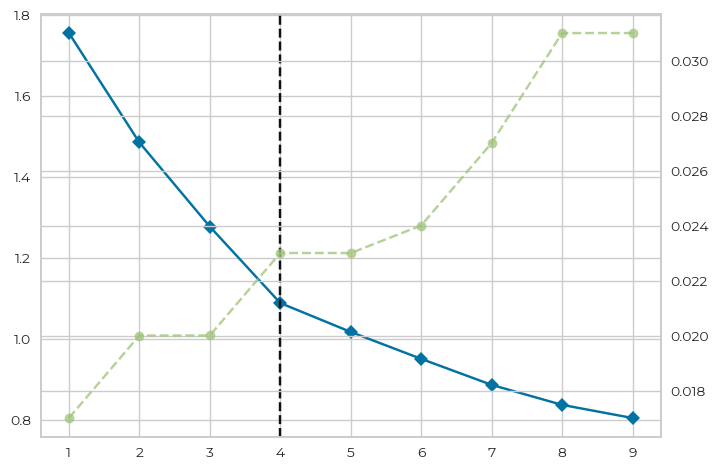

In [552]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(opinion_km_df)

In [773]:
estimator = KMeans(n_clusters=4, random_state=999)
cluster_ids = estimator.fit_predict(opinion_km_df.iloc[:, :12])
opinion_km_df['Cluster'] = cluster_ids
opinion_km_df['Cluster'] = opinion_km_df['Cluster'].map({0: 'A', 1:'B', 2:'C', 3:'D'})

c:\Users\taeyeon_home\anaconda3\envs\py38\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


In [774]:
kmeans_result = opinion_km_df.groupby(['Cluster'], as_index=False).mean()
cluster_size = opinion_km_df.groupby(['Cluster']).size().reset_index(name='Frequency')
kmeans_result = pd.merge(kmeans_result, cluster_size, on='Cluster')

c:\Users\taeyeon_home\anaconda3\envs\py38\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
c:\Users\taeyeon_home\anaconda3\envs\py38\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


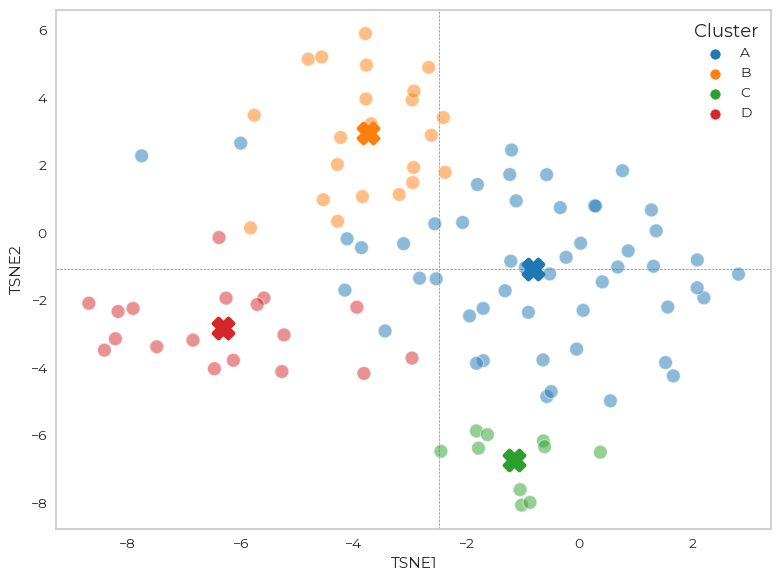

In [784]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(opinion_km_df.iloc[:, :11])

opinion_km_df['TSNE1'] = tsne_result[:, 0]
opinion_km_df['TSNE2'] = tsne_result[:, 1]

plt.rc('font', family='Montserrat', size=13, weight=450)  # weight를 실수 값으로 설정

plt.figure(figsize=(8,6))
ax = sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', data=opinion_km_df, 
                     palette='tab10', hue_order=['A', 'B', 'C', 'D'], s=100, alpha=0.5, zorder=2)

centroids = opinion_km_df.groupby('Cluster').mean()[['TSNE1', 'TSNE2']]

cluster_colors = { 'A': 'tab:blue', 'B': 'tab:orange', 'C': 'tab:green', 'D': 'tab:red' }
for cluster in centroids.index:
    ax.scatter(centroids.loc[cluster, 'TSNE1'], centroids.loc[cluster, 'TSNE2'], 
               marker='X', s=200, linewidths=3, color=cluster_colors[cluster], zorder=3)

plt.grid(False)

ax.axhline(y=opinion_km_df['TSNE2'].mean(), color='grey', linestyle='--', linewidth=0.5, zorder=1)
ax.axvline(x=opinion_km_df['TSNE1'].mean(), color='grey', linestyle='--', linewidth=0.5, zorder=1)

plt.tight_layout()
plt.savefig('./plot/tsne_231003.png', dpi = 600)

In [777]:
kmeans_result = kmeans_result.T
kmeans_result.columns = kmeans_result.iloc[0]
kmeans_result = kmeans_result.drop(kmeans_result.index[0])
kmeans_result

Cluster,A,B,C,D
1,0.074339,0.049341,0.20411,0.070129
2,0.063383,0.068742,0.05008,0.108579
3,0.052091,0.034751,0.035564,0.028297
4,0.07339,0.088176,0.051291,0.163457
5,0.049397,0.03402,0.095962,0.044888
6,0.115466,0.077068,0.079219,0.106346
7,0.158344,0.250199,0.169743,0.128443
8,0.065804,0.072859,0.048976,0.050773
9,0.013661,0.02456,0.011459,0.011692
10,0.068665,0.069808,0.050519,0.054828


In [785]:
kmeans_result.to_excel('result_kmeans_231002.xlsx')